In [1]:
import pandas as pd
import numpy as np
import datasets
# %pip install accelerate=="0.21.0"



/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = datasets.load_dataset("wmt16","de-en", split="train[:50000]")

/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for wmt16 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wmt16
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
validation = datasets.load_dataset("wmt16","de-en", split="validation")

/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for wmt16 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wmt16
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
test = datasets.load_dataset("wmt16","de-en", split= "test")

In [5]:
import numpy as np
def gen_sentences(data):
    english_sentences = [0 for x in range(len(data))]
    german_sentences = [0 for x in range(len(data))]
    for i in range(len(data)):
        english_sentences[i] = data[i]['translation']['en']
        german_sentences[i] = data[i]['translation']['de']
#     english_sentences = torch.from_numpy(english_sentences)
#     german_sentences = torch.from_numpy(german_sentences)
    return english_sentences, german_sentences

In [6]:
train_english_sent, train_german_sentence = gen_sentences(train)

In [7]:
val_english_sent, val_german_sentence = gen_sentences(validation)
test_english_sent, test_german_sentence = gen_sentences(test)

In [8]:
def sentences_to_csv(sentences, translations, filename):
    # Create a DataFrame from the lists of sentences and translations
    df = pd.DataFrame({"de": sentences, "en": translations})
    
    # Write the DataFrame to a CSV file
    df.to_csv(filename, index=False)

In [9]:
sentences_to_csv(train_german_sentence,train_english_sent,'task2_train')

In [10]:
sentences_to_csv(val_german_sentence,val_english_sent,'task2_val')
sentences_to_csv(test_german_sentence,test_english_sent,'task2_test')

In [11]:
%pip install transformers datasets evaluate sacrebleu

Note: you may need to restart the kernel to use updated packages.


In [12]:
train = pd.read_csv('task2_train')
test =  pd.read_csv('task2_test')
val =   pd.read_csv('task2_val')

In [13]:
def in_format(data):
    tr_data = []
    for i in range(data.shape[0]):
        tr_data.append({'translate':{'de': data['de'].iloc[i] , 'en' : data['en'].iloc[i] }})
    return tr_data

In [14]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example for example in examples['de']]
    targets = [example for example in examples['en']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=512, truncation=True)
    
    input = []
    for i in range(len(model_inputs['input_ids'])):
        input.append({'input_ids': model_inputs['input_ids'][i] , 'attention_mask' : model_inputs['attention_mask'][i], 'labels': model_inputs['labels'][i]})
    return model_inputs,input


In [16]:
list_train, tokenized = preprocess_function(train)
list_val, tokenized_val = preprocess_function(val)
list_test, tokenized_test = preprocess_function(test)

In [17]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

2024-04-03 16:16:34.591488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 16:16:34.591534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 16:16:34.592373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 16:16:34.598472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 16:16:35.588793: W tensorflow/compiler/tf2

In [18]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [19]:
import numpy as np
import evaluate

metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from accelerate import DataLoaderConfiguration

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code here

# Restore warnings
warnings.filterwarnings("default")

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None, 
    split_batches=False,
    even_batches=True,
    use_seedable_sampler=True
)

training_args = Seq2SeqTrainingArguments(
    output_dir=".",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=2,  # Set num_train_epochs to 2
    predict_with_generate=True,
    # fp16=True,
    push_to_hub=False,
    report_to = 'none'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # dataloader_config=dataloader_config,  # Pass DataLoaderConfiguration here
    compute_metrics=compute_metrics,
)

# Lists to store training and validation loss
train_losses = []
val_losses = []


train_output = trainer.train()



/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,2.387900,2.129687,8.111800,16.955700
2,2.330400,2.107496,8.425200,16.935500


/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [22]:
# Initialize lists to hold the losses
train_losses = []
train_epochs = []
val_losses = []
val_epochs = []

# Iterate through the log history
for log in trainer.state.log_history:
    # Check for training loss and append when epoch is integer
    if 'loss' in log :
        train_losses.append(log['loss'])
        train_epochs.append(log['epoch'])
    # Check for validation loss and append
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])
        val_epochs.append(log['epoch'])

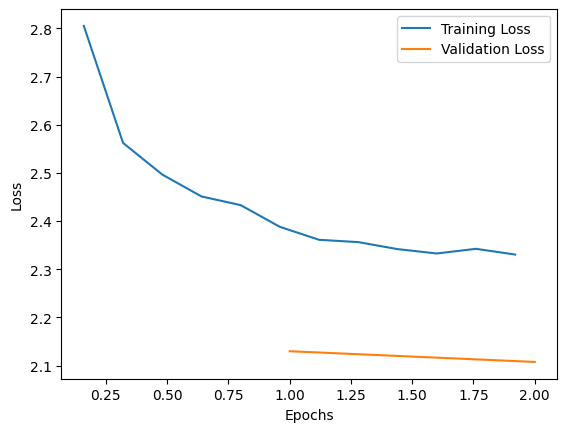

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_epochs,train_losses, label='Training Loss')
plt.plot(val_epochs,val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
from transformers import pipeline
def generate_sentences(data):
    # Sample input text
    decoded_outputs = []
    for i in range(data['de'].shape[0]):
        inputs = data['de'].iloc[i]

        # Tokenize the sample input text
        inputs = tokenizer(prefix + inputs, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        # Generate translations
        generated_output = trainer.model.generate(inputs['input_ids']).to(device)

        # Decode the generated output
        decoded_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
        decoded_outputs.append(decoded_output)

    return decoded_outputs




In [42]:
test_gen = generate_sentences(test[:100])
val_gen = generate_sentences(val[:100])

/home/nsl/nlp/assignment-3/.venv/lib64/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [73]:



from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu_score(reference, translated):
    # Define a smoothing function (e.g., method 1)
    smoothing_function = SmoothingFunction().method1
    
    # Calculate BLEU scores with smoothing
    bleu1 = corpus_bleu(reference, translated, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu2 = corpus_bleu(reference, translated, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu3 = corpus_bleu(reference, translated, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
    bleu4 = corpus_bleu(reference, translated, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
    
    return bleu1, bleu2, bleu3, bleu4


In [74]:

import evaluate

def calculate_meteor(reference,translated):
    # print(reference[0], translated[0])
    meteor_score_val = evaluate.load("meteor")
    results_val = meteor_score_val.compute(predictions=translated, references=reference)
    return results_val['meteor']

# %pip install bert_score
def calculate_bert(reference,translated):
    # print(reference)
    
    bertscore = evaluate.load("bertscore")
    results_val = bertscore.compute(predictions=translated, references=reference, lang="en")
    return np.mean(results_val['precision']), np.mean(results_val['recall']), np.mean(results_val['f1'])

In [80]:
bleu1 , bleu2, bleu3, bleu4 = calculate_bleu_score([x for x in test['en'][:100]], test_gen)
print(f"testing bleu1 score : {bleu1}")
print(f"testing bleu2 score : {bleu2}")
print(f"testing bleu3 score : {bleu3}")
print(f"testing bleu4 score : {bleu4}")

# meteor = calculate_meteor(val_german_sentences , translated_german )
# print(f"Validation meteor score : {meteor}")

bert_precision, bert_recall, bert_f1 = calculate_bert(test['en'][:100] , test_gen )
print(f"testing bert precision : {bert_precision}")
print(f"testing bert recall : {bert_recall}")
print(f"testing bert f1 : {bert_f1}")

meteor = calculate_meteor(test['en'][:100] , test_gen )
print(f"Validation meteor score : {meteor}")

testing bleu1 score : 0.2930364614465033
testing bleu2 score : 0.002108396231736711
testing bleu3 score : 0.00044230674680261964
testing bleu4 score : 0.00018091405013006054


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


testing bert precision : 0.9035027205944062
testing bert recall : 0.8959303492307663
testing bert f1 : 0.8995037561655045


[nltk_data] Downloading package wordnet to /home/nsl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nsl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Validation meteor score : 0.4047427254237272


In [79]:
bleu1 , bleu2, bleu3, bleu4 = calculate_bleu_score(val['en'][:100] , val_gen )
print(f"validation bleu1 score : {bleu1}")
print(f"validation bleu2 score : {bleu2}")
print(f"validation bleu3 score : {bleu3}")
print(f"validation bleu4 score : {bleu4}")



bert_precision, bert_recall, bert_f1 = calculate_bert(val['en'][:100], val_gen  )
print(f"validation bert precision : {bert_precision}")
print(f"validation bert recall : {bert_recall}")
print(f"validation bert f1 : {bert_f1}")

meteor = calculate_meteor(val['en'][:100] , val_gen )
print(f"Validation meteor score : {meteor}")

validation bleu1 score : 0.33486825275006393
validation bleu2 score : 0.3593362774235773
validation bleu3 score : 0.3291921265409505
validation bleu4 score : 0.28192870613077897


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


validation bert precision : 0.8176280361413956
validation bert recall : 0.9182360547780991
validation bert f1 : 0.862238175868988


[nltk_data] Downloading package wordnet to /home/nsl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nsl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Validation meteor score : 0.3214244996155769


In [81]:
# Save the model
output_dir = "."
model.save_pretrained(output_dir, model_name="custom_model")
tokenizer.save_pretrained(output_dir , model_name="custom_tokenizer")

('./tokenizer_config.json', './special_tokens_map.json', './tokenizer.json')

In [ ]:
model_name = "custom_model"
model = AutoModelForSeq2SeqLM.from_pretrained("checkpoint-6000")

In [90]:
tokenizer = AutoTokenizer.from_pretrained("checkpoint-6000")

In [92]:
# Input text
input_text = "translate German to English: Ich bin ein Berliner."

# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

# Generate predictions
outputs = model.generate(**inputs)

# Decode the output
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated output:", output_text)

Generated output: The complex structure of human language and its ability to convey and convey complex concepts creates a
